In [2]:
# import time
# import serial
# # arduino = serial.Serial(port='COM5', baudrate=9600, timeout=.1)
# time.sleep(2)

In [3]:
import os
import cv2
import time
import mediapipe as mp
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm


In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [5]:
keypoints = [
    mp_hands.HandLandmark.WRIST, 
    mp_hands.HandLandmark.THUMB_CMC, 
    mp_hands.HandLandmark.THUMB_MCP, 
    mp_hands.HandLandmark.THUMB_IP, 
    mp_hands.HandLandmark.THUMB_TIP, 
    mp_hands.HandLandmark.INDEX_FINGER_MCP, 
    mp_hands.HandLandmark.INDEX_FINGER_PIP, 
    mp_hands.HandLandmark.INDEX_FINGER_DIP, 
    mp_hands.HandLandmark.INDEX_FINGER_TIP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_MCP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_PIP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_DIP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_TIP,
    mp_hands.HandLandmark. RING_FINGER_MCP,
    mp_hands.HandLandmark.RING_FINGER_PIP,
    mp_hands.HandLandmark.RING_FINGER_DIP,
    mp_hands.HandLandmark.RING_FINGER_TIP,  
    mp_hands.HandLandmark.PINKY_MCP,
    mp_hands.HandLandmark.PINKY_PIP,
    mp_hands.HandLandmark.PINKY_DIP,
    mp_hands.HandLandmark.PINKY_TIP
    ]
    

In [6]:
if not os.path.exists('Dataset.csv'):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2,min_detection_confidence=0.5) as hands:
        list_name = ["Wrist_x", "Wrist_y", "Thumb_cmc_x", "Thumb_cmc_y", "Thumb_mcp_x", "Thumb_mcp_y", "Thumb_ip_x", "Thumb_ip_y", "Thumb_tip_x",   "Thumb_tip_y", "Index_finger_mcp_x", "Index_finger_mcp_y", "Index_finger_pip_x", "Index_finger_pip_y", "Index_finger_dip_x",  "Index_finger_dip_y", "Index_finger_tip_x", "Index_finger_tip_y", "Middle_finger_mcp_x", "Middle_finger_mcp_y", "Middle_finger_pip_x",   "Middle_finger_pip_y", "Middle_finger_dip_x", "Middle_finger_dip_y", "Middle_finger_tip_x", "Middle_finger_tip_y", "Ring_finger_mcp_x",   "Ring_finger_mcp_y", "Ring_finger_pip_x", "Ring_finger_pip_y", "Ring_finger_dip_x", "Ring_finger_dip_y", "Ring_finger_tip_x",     "Ring_finger_tip_y", "Pinky_mcp_x", "Pinky_mcp_y", "Pinky_pip_x", "Pinky_pip_y", "Pinky_dip_x", "Pinky_dip_y", "Pinky_tip_x",   "Pinky_tip_y"]
        header = ["filename", "class_name","class_no"]
        for i in range(len(list_name)):
            header.append(list_name[i])
        with open("Dataset.csv", "w") as f:
            f.write(",".join(header) + "\n")
        for class_ in os.listdir("Dataset"):
            for image in tqdm(os.listdir("Dataset/" + class_), desc="Processing", unit="image", total=len(os.listdir("Dataset/" + class_))):
                image_path = "Dataset/" + class_ + "/" + image
                image = cv2.flip(cv2.imread(image_path), 1)
                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if not results.multi_hand_landmarks:
                    continue
                for hand_landmarks in results.multi_hand_landmarks:
                    row = [image_path, class_, os.listdir("Dataset").index(class_)]
                    for i in range(len(keypoints)):
                        row.append(hand_landmarks.landmark[keypoints[i]].x)
                        row.append(hand_landmarks.landmark[keypoints[i]].y)
                    with open("Dataset.csv", "a") as f:
                        f.write(",".join([str(i) for i in row]) + "\n")



In [7]:
csvs_out_train_path = 'Dataset.csv'

In [8]:
def get_coords(csv_path):
  
  df = pd.read_csv(csv_path)
  df1= df.copy()
  df1.drop(columns=['filename'], inplace=True)
  classes = df1.pop('class_name').unique()
  y = df1.pop('class_no')
  x = df1.astype('float64')
  y = keras.utils.to_categorical(y)

  return x, y, classes, df


In [9]:
x, y, classes, df = get_coords(csvs_out_train_path)

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size=0.15)

In [10]:
def embed_coords(scores):
  
  reshaped_inputs = keras.layers.Reshape((21, 2))(scores)
  points = reshaped_inputs
  embedding = keras.layers.Flatten()(points)
  
  return embedding

In [11]:
inputs = tf.keras.Input(shape=(42))
embedding = embed_coords(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(classes), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 reshape (Reshape)           (None, 21, 2)             0         
                                                                 
 flatten (Flatten)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

Epoch 1/200
2039/2069 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.7718
Epoch 1: val_accuracy improved from -inf to 0.91353, saving model to weights.best.hdf5
2069/2069 [==============================] - 2s 976us/step - loss: 0.5602 - accuracy: 0.7735 - val_loss: 0.1691 - val_accuracy: 0.9135
Epoch 2/200
2019/2069 [============================>.] - ETA: 0s - loss: 0.2231 - accuracy: 0.9008
Epoch 2: val_accuracy improved from 0.91353 to 0.95925, saving model to weights.best.hdf5
2069/2069 [==============================] - 2s 905us/step - loss: 0.2217 - accuracy: 0.9015 - val_loss: 0.1103 - val_accuracy: 0.9592
Epoch 3/200
2031/2069 [============================>.] - ETA: 0s - loss: 0.1512 - accuracy: 0.9425
Epoch 3: val_accuracy improved from 0.95925 to 0.99041, saving model to weights.best.hdf5
2069/2069 [==============================] - 2s 892us/step - loss: 0.1506 - accuracy: 0.9427 - val_loss: 0.0391 - val_accuracy: 0.9904
Epoch 4/200
2040/2069 [========

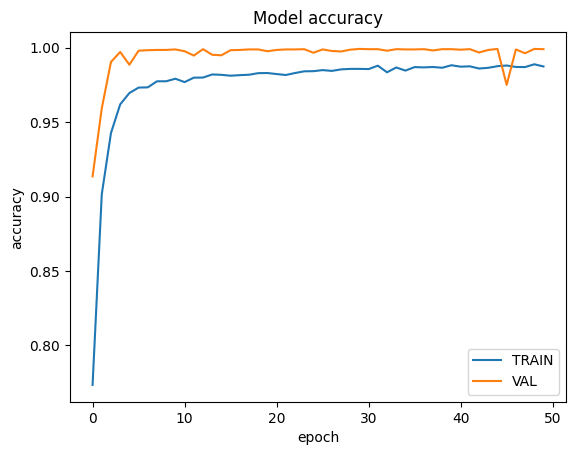

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)


history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, earlystopping])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

183/183 [==============================] - 0s 470us/step
(5840, 42) (5840, 6) <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

      Class0       0.99      1.00      1.00       856
      Class1       1.00      0.99      1.00       998
      Class2       1.00      1.00      1.00      1028
      Class3       1.00      1.00      1.00      1460
      Class4       1.00      1.00      1.00       736
      Class5       1.00      1.00      1.00       762

    accuracy                           1.00      5840
   macro avg       1.00      1.00      1.00      5840
weighted avg       1.00      1.00      1.00      5840



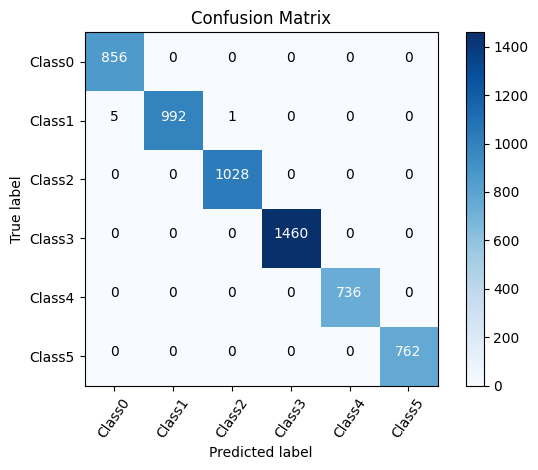

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

y_pred = model.predict(x_val)
print(x_val.shape, y_pred.shape, type(y_pred), type(x_val))

y_pred_label = [classes[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [classes[i] for i in np.argmax(y_val, axis=1)]

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      classes,
                      title ='Confusion Matrix')

print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [14]:
x_val.shape

(5840, 42)

In [15]:
def findSpeed(image):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2,min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.multi_hand_landmarks:
            return None, None
        coordinates = np.array([[res.x, res.y] for res in results.multi_hand_landmarks[0].landmark]).flatten()
        X = coordinates.reshape(1, 42)
        y = model.predict(X)
        y_pred = [classes[i] for i in np.argmax(y, axis=1)]
        return y_pred[0], np.argmax(y, axis=1)[0]

In [16]:
findSpeed(cv2.imread("Dataset\\Class4\\image37.jpg"))

1/1 [==============================] - 0s 40ms/step


('Class4', 4)

In [17]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 720)
cv2.namedWindow('Hand Gesture Recognition', cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    ok, frame = camera_video.read()
    time1 = time.time()
    if not ok:
        continue

    frame_height, frame_width, _ = frame.shape
   
    fingers, num = findSpeed(frame)
    print(fingers)
    # if num is not None:
    #     if num == 0:
    #         arduino.write(b'0')
    #     if num == 1:
    #         arduino.write(b'1')
    #     if num == 2:
    #         arduino.write(b'2')
    #     if num == 3:
    #         arduino.write(b'3')
    #     if num == 4:
    #         arduino.write(b'4')
    #     if num == 5:
    #         arduino.write(b'5')
    frame = cv2.flip(frame, 1)
    time2 = time.time()
    fps = 0
    if (time2 - time1) > 0:
        fps = 1.0 / (time2 - time1)
    cv2.putText(frame, 'FPS: {}'.format(int(fps)), (500, 150),
                cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)
    cv2.putText(frame, 'CLASS: {}'.format(fingers), (10, 150),
                 cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)
    time1 = time2
    
    cv2.imshow('Hand Gesturen Recognition', frame)
    k = cv2.waitKey(1) & 0xFF
    if(k==27):
        break
camera_video.release()
cv2.destroyAllWindows()

None
None
1/1 [==============================] - 0s 14ms/step
Class1
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 14ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
1/1 [==============================] - 0s 13ms/step
Class0
None
1/1 [=========================